In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
pio.renderers.default = "png"

from data import *
from plotting import *
from regression import *
from utils import *

In [3]:
# Load data
pcd_df = load_pcd_df()

access_df = pcd_df.dropna(subset=['Model accessibility'])
len(access_df)

990

In [4]:
model_open_categories = ['Open source', 'Open access (restricted use)', 'Open access (non-commercial)']
code_open_categories = ['Open source', 'Open access (non-commercial)', 'Open access (restricted use)']


# Add open/closed binary columns
access_df['Model open/closed'] = access_df['Model accessibility'].apply(
    lambda x: 'Open' if x in model_open_categories else 'Closed'
)

access_df['Code open/closed'] = access_df['Code accessibility'].apply(
    lambda x: 'Open' if x in code_open_categories else 'Closed'
)

/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_46006/803333015.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_46006/803333015.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
open_df = access_df.loc[access_df['Model open/closed'] == 'Open']

In [6]:
notable = open_df.loc[(open_df['Notability criteria'].notna())]
print(len(notable))
notable.head(10)

218


,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Code open/closed
3,Nemotron-4 340B,Language,"Language modelling/generation,Chat",2024-06-14,Permissive commercial license: https://develop...,Open source,NaN,Unreleased,https://blogs.nvidia.com/blog/nemotron-4-synth...,NVIDIA,...,NaN,NaN,NaN,700.0,0,NaN,1.800000e+25,100%,Open,Closed
8,Llama 3-70B,Language,"Chat,Language modelling/generation,Code genera...",2024-04-18,https://github.com/meta-llama/llama3/blob/main...,Open access (restricted use),NaN,Open access (restricted use),https://ai.meta.com/blog/meta-llama-3/,Meta AI,...,NaN,"""Our most efficient implementation achieves a ...",NaN,700.0,11200000,NaN,6.300000e+24,100%,Open,Open
11,Falcon-180B,Language,Language modelling,2023-09-06,"""Falcon 180b can be commercially used but unde...",Open access (restricted use),NaN,Unreleased,https://falconllm.tii.ae/falcon-180b.html; htt...,Technology Innovation Institute,...,NaN,Estimated training compute: 3.76e24\nFLOPs at ...,NaN,400.0,1638400,NaN,3.760000e+24,100%,Open,Closed
13,Grok-1,Language,"Language modelling,Chat",2023-11-04,apache 2.0,Open source,Unreleased,Unreleased,"https://x.ai/model-card/, https://x.ai/blog/gr...",xAI,...,NaN,NaN,NaN,NaN,0,NaN,2.900000e+24,100%,Open,Closed
23,Qwen-72B,Language,"Chat,Code generation",2023-11-30,up to 100m active users:\nhttps://github.com/Q...,Open access (restricted use),Unreleased,Unreleased,https://huggingface.co/Qwen/Qwen-72B,Alibaba,...,NaN,NaN,NaN,NaN,0,NaN,1.300000e+24,100%,Open,Closed
24,DeepSeek-Coder-V2-236B,Language,"Code generation,Code autocompletion",2024-06-17,license has some harmful use restrictions: htt...,Open access (restricted use),Unreleased,Unreleased,https://github.com/deepseek-ai/DeepSeek-Coder-V2,DeepSeek,...,DeepSeek-Coder-V2-236B,NaN,NaN,NaN,0,NaN,1.285200e+24,100%,Open,Closed
36,Llama 2-70B,Language,Language modelling,2023-07-18,Llama 2 license. can't use outputs to train mo...,Open access (restricted use),NaN,Unreleased,https://ai.meta.com/research/publications/llam...,Meta AI,...,NaN,8.1e23 FLOPs based on 6NC method.\nTable 2 rep...,NaN,400.0,400000,NaN,8.100000e+23,100%,Open,Closed
38,Llama 3-8B,Language,"Chat,Language modelling/generation,Code genera...",2024-04-18,https://github.com/meta-llama/llama3/blob/main...,Open access (restricted use),NaN,Open access (restricted use),https://ai.meta.com/blog/meta-llama-3/,Meta AI,...,NaN,"""Our most efficient implementation achieves a ...",NaN,700.0,11200000,NaN,7.200000e+23,100%,Open,Open
42,Yi-34B,Language,"Chat,Language modelling/generation,Translation...",2023-11-02,apply for commercial license:\nno training cod...,Open access (restricted use),NaN,Unreleased,https://arxiv.org/abs/2403.04652,01.AI,...,NaN,NaN,NaN,NaN,0,NaN,6.100000e+23,100%,Open,Closed
43,BLOOM-176B,Language,Language modelling,2022-11-08,responsible use restrictions: https://bigscien...,Open access (restricted use),NaN,Unreleased,https://arxiv.org/abs/2211.05100,"Hugging Face,BigScience",...,NaN,"""We were able to achieve 156 TFLOPs in our fas...",NaN,400.0,153600,NaN,5.770000e+23,100%,Open,Closed


In [7]:
non_notable = open_df.loc[(open_df['Notability criteria'].isna())]
print(len(non_notable))
non_notable.head(10)
# 251 open but not "notable"
# some of these are clearly lower-n notable, like Qwen2, DBRX, Gemma 2, DeepSeek coder
# possible other criteria - within 1 (or 1.5 or 2) OOM training compute of frontier (1.5 OOM is ~1e24 right now)
# greater than 1000 (or 1100) on chatbot arena?

251


,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Code open/closed
12,Qwen2-72B,Language,"Chat,Language modelling/generation",2024-06-07,Apache 2.0,Open source,NaN,Unreleased,https://qwenlm.github.io/blog/qwen2/ \nhttps:/...,Alibaba,...,NaN,NaN,NaN,NaN,0,NaN,3.020000e+24,100%,Open,Closed
15,DBRX,Language,"Chat,Code generation",2024-03-27,license: https://www.databricks.com/legal/open...,Open access (restricted use),Unreleased,Unreleased,https://www.databricks.com/blog/introducing-db...,Databricks,...,DBRX,NaN,NaN,700.0,0,NaN,2.600000e+24,100%,Open,Closed
20,Gemma 2 27B,Language,"Language modelling/generation,Chat",2024-06-24,Gemma 2 is available under our \ncommercially-...,Open access (restricted use),NaN,Unreleased,https://storage.googleapis.com/deepmind-media/...,Google DeepMind,...,NaN,NaN,NaN,NaN,0,NaN,2.106000e+24,100%,Open,Closed
22,Chameleon-34B,"Multimodal,Image generation,Language,Vision","Language modelling/generation,Vision-language ...",2024-05-16,https://ai.meta.com/resources/models-and-libra...,Open access (non-commercial),NaN,Unreleased,https://arxiv.org/abs/2405.09818v1,Facebook AI Research,...,NaN,NaN,NaN,400.0,1228800,NaN,1.645357e+24,100%,Open,Closed
25,Code Llama-70B,Language,Code generation,2024-01-29,Llama 2 license. can't use outputs to train mo...,Open access (restricted use),NaN,Unreleased,https://ai.meta.com/research/publications/code...,Meta AI,...,NaN,"Based on 6NC estimate, fine tuning required ar...",NaN,400.0,160000,8.100000e+23,3.000000e+22,2%,Open,Closed
26,XVERSE-65B-2,Language,"Chat,Language modelling/generation",2023-12-08,Apache 2.0\n\nThe use of the source code in th...,Open access (restricted use),NaN,Open source,https://github.com/xverse-ai/XVERSE-65B/blob/m...,"XVERSE Technology,Shenzhen Yuanxiang Technology",...,NaN,NaN,NaN,NaN,0,NaN,1.248000e+24,100%,Open,Open
32,TigerBot-70B,Language,"Chat,Language generation,Language modelling/ge...",2023-09-06,Apache 2.0 https://github.com/TigerResearch/Ti...,Open access (restricted use),NaN,Open source,https://github.com/TigerResearch/TigerBot/blob...,Tigerobo,...,NaN,NaN,NaN,NaN,0,8.100000e+23,8.400000e+22,8%,Open,Open
33,DeepSeek-V2,Language,"Language modelling/generation,Chat",2024-05-07,open weights with harmful use restrictions: ht...,Open access (restricted use),Unreleased,Unreleased,https://arxiv.org/abs/2405.04434 \nhttps://git...,DeepSeek,...,NaN,NaN,NaN,NaN,0,NaN,1.020000e+24,100%,Open,Closed
37,DeepSeek LLM 67B,Language,Chat,2024-01-05,"repo with inference code and details, but no t...",Open access (restricted use),NaN,Unreleased,"https://arxiv.org/abs/2401.02954, https://gith...",DeepSeek,...,NaN,NaN,NaN,NaN,0,NaN,8.040000e+23,100%,Open,Closed
47,Guanaco-65B,Language,Chat,2023-05-23,"LLaMA license, non-commercial for weights. cod...",Open access (non-commercial),NaN,Open source,https://arxiv.org/abs/2305.14314; https://gith...,University of Washington,...,NaN,NaN,NaN,NaN,0,5.500000e+23,-8.000000e+18,-0%,Open,Open


In [8]:
print(f"Models that are not fine-tunes:  {len(open_df.loc[open_df['Base model'].isna()])}")
print(f"Models that are fine-tunes:  {len(open_df.loc[open_df['Base model'].notna()])}")
open_df.loc[open_df['Base model'].notna()].head(10)

Models that are not fine-tunes:  391
Models that are fine-tunes:  78


,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Code open/closed
25,Code Llama-70B,Language,Code generation,2024-01-29,Llama 2 license. can't use outputs to train mo...,Open access (restricted use),NaN,Unreleased,https://ai.meta.com/research/publications/code...,Meta AI,...,NaN,"Based on 6NC estimate, fine tuning required ar...",NaN,400.0,160000,8.100000e+23,3.000000e+22,2%,Open,Closed
32,TigerBot-70B,Language,"Chat,Language generation,Language modelling/ge...",2023-09-06,Apache 2.0 https://github.com/TigerResearch/Ti...,Open access (restricted use),NaN,Open source,https://github.com/TigerResearch/TigerBot/blob...,Tigerobo,...,NaN,NaN,NaN,NaN,0,8.100000e+23,8.400000e+22,8%,Open,Open
47,Guanaco-65B,Language,Chat,2023-05-23,"LLaMA license, non-commercial for weights. cod...",Open access (non-commercial),NaN,Open source,https://arxiv.org/abs/2305.14314; https://gith...,University of Washington,...,NaN,NaN,NaN,NaN,0,5.500000e+23,-8.000000e+18,-0%,Open,Open
49,Code Llama-34B,Language,Code generation,2023-08-14,Llama 2 license. can't use outputs to train mo...,Open access (restricted use),NaN,Unreleased,https://ai.meta.com/research/publications/code...,Meta AI,...,NaN,NaN,NaN,400.0,0,4.080000e+23,0.000000e+00,0%,Open,Closed
54,OPT-IML (175B),Language,Language modelling,2022-12-22,unclear license\nhttps://huggingface.co/facebo...,Open access (non-commercial),NaN,Unreleased,https://arxiv.org/abs/2212.12017,Meta AI,...,NaN,NaN,NaN,400.0,51200,4.300000e+23,-2.100000e+21,-0%,Open,Closed
55,BlenderBot 3,Language,Chat,2022-08-10,"weights have a non-commercial license, must go...",Open access (non-commercial),Open source,Open access (non-commercial),"https://arxiv.org/abs/2208.03188, https://gith...","McGill University,Meta AI,Mila - Quebec AI (or...",...,NaN,NaN,NaN,400.0,51200,4.300000e+23,-1.500000e+21,-0%,Open,Open
63,FunSearch,"Language,Search",Code generation,2023-12-14,Code to run FunSearch with an LLM of your choi...,Open source,NaN,Unreleased,https://www.nature.com/articles/s41586-023-069...,Google DeepMind,...,FunSearch,NaN,NaN,NaN,0,7.340000e+24,-6.953000e+24,-1797%,Open,Closed
100,FinGPT-13B,Language,"Named entity recognition,Sentiment classificat...",2023-10-07,MIT license (though probably subject to Llama ...,Open source,Open source,Open source,https://arxiv.org/abs/2310.04793; https://gith...,"University of California Los Angeles (UCLA),Co...",...,NaN,NaN,NaN,350.0,350,1.600000e+23,-6.532488e+17,-0%,Open,Open
102,Llama Guard,Language,Chat,2023-12-07,Llama 2 license\nhttps://github.com/facebookre...,Open access (restricted use),Unreleased,Unreleased,https://arxiv.org/abs/2312.06674,Meta AI,...,NaN,NaN,NaN,400.0,0,8.400000e+22,7.599983e+22,47%,Open,Closed
114,WizardCoder-15.5B,Language,Code generation,2023-06-14,"commercial, responsible use restrictions: http...",Open access (restricted use),Open access (non-commercial),Open source,https://arxiv.org/abs/2306.08568,Microsoft,...,NaN,NaN,NaN,NaN,0,8.460000e+22,2.738050e+22,24%,Open,Open


In [9]:
notable_finetunes = open_df.loc[(open_df['Base model'].notna()) & (open_df['Notability criteria'].notna())]
print(len(notable_finetunes))
notable_finetunes[['System', 'Notability criteria']]
# 33 notable, fine-tuned open models



33


,System,Notability criteria
55,BlenderBot 3,SOTA improvement
63,FunSearch,"SOTA improvement,Historical significance"
100,FinGPT-13B,SOTA improvement
102,Llama Guard,SOTA improvement
153,Taiyi-Stable Diffusion,Historical significance
164,Volcano 13B,SOTA improvement
166,LLaVA 1.5,SOTA improvement
190,Flan-T5 11B,Highly cited
207,CogVLM,SOTA improvement
252,VideoMAE V2,SOTA improvement


In [10]:
open_df.groupby('Domain').size().sort_values(ascending=False)

Domain
Language                                                    301
Biology                                                      44
Vision                                                       40
Multimodal,Language,Vision                                   13
Image generation                                             11
Speech                                                        9
Games                                                         4
Vision,Image generation                                       4
Audio                                                         3
Robotics                                                      3
Earth science                                                 3
Multimodal,Vision,Language                                    3
Language,Biology                                              2
Vision,Language                                               2
Video                                                         2
Language,Vision,Multimodal       

# Model Accessibility Charts

In [11]:
# Add year column
access_df['Year'] = pd.to_datetime(access_df['Publication date']).dt.year

# Get counts of all models by year and model accessibility
# Only include 2015 and later because older models are rare
access_counts = access_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model accessibility']).size().reset_index(name='Count')

# Add up cumulative counts by accessibility status for each year 
access_counts['Cumulative for status'] = access_counts.groupby('Model accessibility')['Count'].cumsum()

# Sort from most closed to most open
sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open access (non-commercial)', 'Open access (restricted use)', 'Open source']
access_counts['Category_sorted'] = pd.Categorical(access_counts['Model accessibility'], categories=sort_order, ordered=True)
access_counts = access_counts.sort_values(['Category_sorted', 'Year'])

access_counts.head(20)

/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_46006/399375725.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,Model accessibility,Count,Cumulative for status,Category_sorted
1,2015,Unreleased,6,6,Unreleased
5,2016,Unreleased,19,25,Unreleased
7,2017,Unreleased,30,55,Unreleased
10,2018,Unreleased,45,100,Unreleased
14,2019,Unreleased,93,193,Unreleased
18,2020,Unreleased,55,248,Unreleased
23,2021,Unreleased,74,322,Unreleased
29,2022,Unreleased,49,371,Unreleased
35,2023,Unreleased,40,411,Unreleased
41,2024,Unreleased,15,426,Unreleased


In [12]:
# Cumulative area chart
fig = px.area(access_counts, x='Year', y='Cumulative for status', color='Model accessibility', line_group='Model accessibility',
              labels={'Cumulative for status': 'Cumulative Count', 'Year': 'Year'},
              title='Model count by accessibility over time')

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)

# save_plot(fig, results_dir, f'cumulative_model_count_by_accessibility')

fig.show()

Commentary: around half of models are unreleased as of 2024, but the proportion has been shrinking over time. Before 2018 or so, releasing model weights was rare (academic projects often shared training code, but not weights)

In [13]:
# Input -  model counts, grouped by accessibility and by year
# Output - same dataframe with cumulative counts for status and cumulative total across all statuses
def normalize_counts(access_counts):
    
    # Get df with total models per year, and cumulative totals
    total_counts = access_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
    total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
    
    # Pivot the access counts table to get counts for every status and every year
    # This will have many NaN values because not every year has a model of every status
    access_counts_wide = access_counts.pivot(index='Year', columns='Model accessibility', values='Cumulative for status')
    all_years = pd.Series(range(access_counts_wide.index.min(), access_counts_wide.index.max() + 1))

    # Fill in the NaN values
    access_counts_wide_filled = access_counts_wide.reindex(all_years).ffill().fillna(0)
    access_counts_wide_filled = access_counts_wide_filled.reset_index(names=["Year"])
    
    # Unpivot
    access_counts_filled = (access_counts_wide_filled.melt(id_vars='Year', 
                                     var_name='Model accessibility', 
                                     value_name='Cumulative for status')
                               .reset_index(drop=True))
    
    # Join with total counts df to get the cumulative totals
    normalized_counts = pd.merge(access_counts_filled, total_counts, on='Year')
    
    # Divide annual counts by cumulative counts to find cumulative proportions by year
    normalized_counts['proportion'] = normalized_counts['Cumulative for status'] / normalized_counts['Cumulative Total']
    
    # Sort using custom order
    sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open access (non-commercial)', 'Open access (restricted use)', 'Open source']
    normalized_counts['Category_sorted'] = pd.Categorical(normalized_counts['Model accessibility'], categories=sort_order, ordered=True)
    normalized_counts = normalized_counts.sort_values(['Category_sorted', 'Year'])
    
    return normalized_counts

In [14]:
normalized_counts = normalize_counts(access_counts)

normalized_counts.head(20)

,Year,Model accessibility,Cumulative for status,Yearly Total,Cumulative Total,proportion,Category_sorted
50,2015,Unreleased,6.0,8,8,0.750000,Unreleased
51,2016,Unreleased,25.0,23,31,0.806452,Unreleased
52,2017,Unreleased,55.0,31,62,0.887097,Unreleased
53,2018,Unreleased,100.0,67,129,0.775194,Unreleased
54,2019,Unreleased,193.0,141,270,0.714815,Unreleased
55,2020,Unreleased,248.0,95,365,0.679452,Unreleased
56,2021,Unreleased,322.0,143,508,0.633858,Unreleased
57,2022,Unreleased,371.0,134,642,0.577882,Unreleased
58,2023,Unreleased,411.0,242,884,0.464932,Unreleased
59,2024,Unreleased,426.0,87,971,0.438723,Unreleased


In [15]:
fig = px.area(normalized_counts, x='Year', y='proportion', color='Model accessibility', line_group='Model accessibility',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative proportion of models by accessibility over time')

fig.update_yaxes(range=[0, 1])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)

# save_plot(fig, results_dir, f'proportion_by_accessibility')
fig.show()

This chart shows the proportions over time more clearly - open weights have never been very rare (at least 10%). But open models have become much more common over time, making up around half of models today. The large majority of those are permissively licensed ("Open source") even today but open with restrictions has become more common over time.

# Code vs Model Accessibility

In [16]:
print(f"There are {len(access_df[access_df['Code accessibility'].isna()])} models with marked code access and unmarked code access")

There are 114 models with marked code access and unmarked code access


In [17]:
# filter for code accessibility
filtered_df = access_df.dropna(subset=['Code accessibility'])

In [18]:
filtered_df.head(8)

,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Code open/closed,Year
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",2023-12-06,NaN,Hosted access (no API),NaN,Unreleased,https://storage.googleapis.com/deepmind-media/...,Google DeepMind,...,NaN,NaN,192.0,10560000,NaN,5.000000e+25,100%,Closed,Closed,2023
1,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,2023-03-15,NaN,API access,NaN,Unreleased,https://arxiv.org/abs/2303.08774,OpenAI,...,(Speculative) SemiAnalysis conjectures that GP...,NaN,400.0,10000000,NaN,2.100000e+25,100%,Closed,Closed,2023
2,Mistral Large,Language,Chat,2024-02-26,NaN,API access,NaN,Unreleased,https://mistral.ai/news/mistral-large/,Mistral AI,...,NaN,NaN,350.0,0,NaN,2.000000e+25,100%,Closed,Closed,2024
3,Nemotron-4 340B,Language,"Language modelling/generation,Chat",2024-06-14,Permissive commercial license: https://develop...,Open source,NaN,Unreleased,https://blogs.nvidia.com/blog/nemotron-4-synth...,NVIDIA,...,NaN,NaN,700.0,0,NaN,1.800000e+25,100%,Open,Closed,2024
4,MegaScale (Production),Language,Language modelling/generation,2024-02-23,Code for MegaScale (also called veScale) train...,Unreleased,NaN,Unreleased,https://arxiv.org/abs/2402.15627,"ByteDance,Peking University",...,NaN,NaN,400.0,4915200,NaN,1.200000e+25,100%,Closed,Closed,2024
5,Inflection-2,Language,"Language modelling,Language modelling/generati...",2023-11-22,"via Pi, no API",Hosted access (no API),NaN,Unreleased,https://inflection.ai/inflection-2,Inflection AI,...,NaN,NaN,700.0,3500000,NaN,1.001000e+25,100%,Closed,Closed,2023
6,Inflection-2.5,Language,Chat,2024-03-07,NaN,Hosted access (no API),NaN,Unreleased,https://inflection.ai/inflection-2-5,Inflection AI,...,NaN,NaN,700.0,0,NaN,1.000100e+25,100%,Closed,Closed,2024
7,PaLM 2,Language,"Language modelling,Language modelling/generation",2023-05-10,NaN,API access,NaN,Unreleased,https://arxiv.org/abs/2305.10403,Google,...,NaN,NaN,192.0,0,NaN,7.340000e+24,100%,Closed,Closed,2023


In [19]:
model_counts = filtered_df.groupby('Model accessibility').size().reset_index(name='Counts')
model_counts

,Model accessibility,Counts
0,API access,36
1,Hosted access (no API),21
2,Open access (non-commercial),76
3,Open access (restricted use),54
4,Open source,269
5,Unreleased,420


In [20]:
code_counts = filtered_df.groupby('Code accessibility').size().reset_index(name='Counts')
code_counts

,Code accessibility,Counts
0,Open access (non-commercial),77
1,Open access (restricted use),7
2,Open source,339
3,Unreleased,453


In [21]:
counts = filtered_df.groupby(['Model accessibility', 'Code accessibility']).size().reset_index(name='Counts')
pivoted = counts.pivot(index='Model accessibility', columns='Code accessibility', values='Counts').fillna(0).style.format("{:.0f}")

# code access against model access
pivoted

Code accessibility,Open access (non-commercial),Open access (restricted use),Open source,Unreleased
Model accessibility,,,,
API access,0,0,0,36
Hosted access (no API),1,0,1,19
Open access (non-commercial),38,1,16,21
Open access (restricted use),0,4,14,36
Open source,2,1,199,67
Unreleased,36,1,109,274


In [22]:
open_counts = filtered_df.groupby(['Model open/closed', 'Code open/closed']).size().reset_index(name='Counts')
open_counts = open_counts.pivot(index='Model open/closed', columns='Code open/closed', values='Counts')

# code open vs model open
open_counts

Code open/closed,Closed,Open
Model open/closed,,
Closed,329,148
Open,124,275


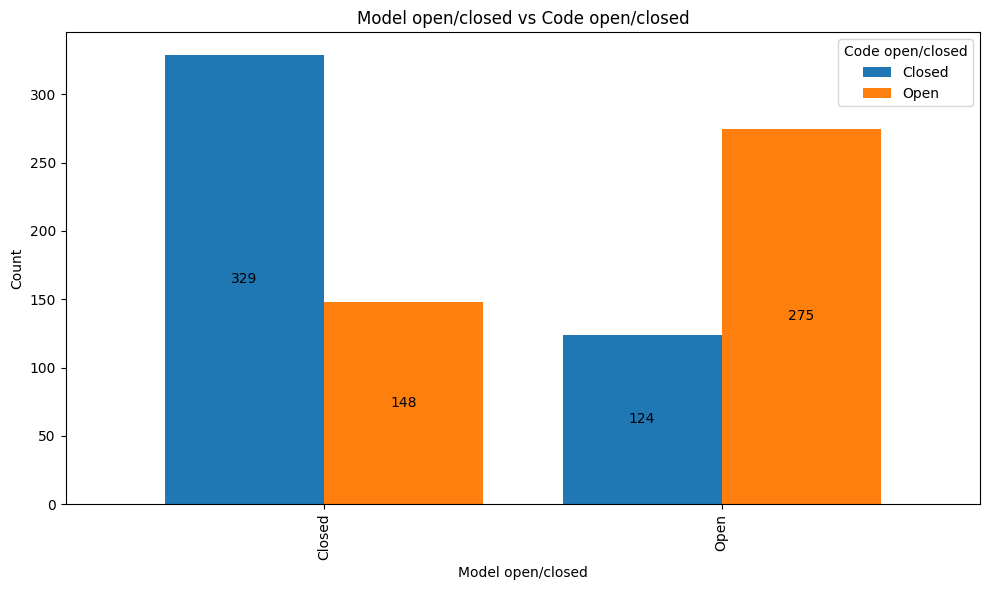

In [23]:
ax = open_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Customize the chart
plt.title('Model open/closed vs Code open/closed')
plt.ylabel('Count')


# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

Model openness and code openness are reasonably correlated - most closed-weight models have closed code, while somewhat more open models have open code than closed code. This also applies across the other direction - most closed code models have closed weights, most open code models have open weights.

In [24]:
open_counts = filtered_df.loc[filtered_df['Year'] >= 2015].groupby(['Year', 'Model open/closed', 'Code open/closed']).size().reset_index(name='Count')

open_counts['Cumulative'] = open_counts.groupby(['Model open/closed', 'Code open/closed'])['Count'].cumsum()

open_counts.head(10)

,Year,Model open/closed,Code open/closed,Count,Cumulative
0,2015,Closed,Closed,5,5
1,2015,Closed,Open,1,1
2,2015,Open,Open,2,2
3,2016,Closed,Closed,18,23
4,2016,Closed,Open,2,3
5,2016,Open,Open,2,4
6,2017,Closed,Closed,15,38
7,2017,Closed,Open,13,16
8,2017,Open,Open,1,5
9,2018,Closed,Closed,32,70


In [25]:
total_counts = open_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
total_counts

,Year,Yearly Total,Cumulative Total
0,2015,8,8
1,2016,22,30
2,2017,29,59
3,2018,65,124
4,2019,138,262
5,2020,91,353
6,2021,137,490
7,2022,117,607
8,2023,188,795
9,2024,62,857


In [26]:
open_counts_wide = open_counts.pivot(index='Year', columns=['Model open/closed', 'Code open/closed'], values='Count')
open_counts_wide = open_counts_wide.fillna(0).reset_index()
open_counts_wide

Model open/closed  Year Closed        Open       
Code open/closed        Closed  Open  Open Closed
0                  2015    5.0   1.0   2.0    0.0
1                  2016   18.0   2.0   2.0    0.0
2                  2017   15.0  13.0   1.0    0.0
3                  2018   32.0  11.0  21.0    1.0
4                  2019   56.0  36.0  37.0    9.0
5                  2020   40.0  15.0  30.0    6.0
6                  2021   49.0  30.0  51.0    7.0
7                  2022   30.0  21.0  48.0   18.0
8                  2023   47.0  11.0  70.0   60.0
9                  2024   22.0   4.0  13.0   23.0

In [27]:
print(open_counts_wide.columns.to_list())
print(open_counts_wide.index.names)

[('Year', ''), ('Closed', 'Closed'), ('Closed', 'Open'), ('Open', 'Open'), ('Open', 'Closed')]
[None]


In [28]:
# Convert pivoted multi-columns to single columns with clear names
new_columns = ['Year'] + [f'Model {outer} Code {inner}' for outer, inner in open_counts_wide.columns[1:]]
open_counts_wide.columns = new_columns

open_counts_wide

,Year,Model Closed Code Closed,Model Closed Code Open,Model Open Code Open,Model Open Code Closed
0,2015,5.0,1.0,2.0,0.0
1,2016,18.0,2.0,2.0,0.0
2,2017,15.0,13.0,1.0,0.0
3,2018,32.0,11.0,21.0,1.0
4,2019,56.0,36.0,37.0,9.0
5,2020,40.0,15.0,30.0,6.0
6,2021,49.0,30.0,51.0,7.0
7,2022,30.0,21.0,48.0,18.0
8,2023,47.0,11.0,70.0,60.0
9,2024,22.0,4.0,13.0,23.0


In [29]:
# unpivot table to get the count of each 2x2 value for each year
open_counts_filled = (open_counts_wide.melt(id_vars=['Year'], 
                                            var_name='Category',
                                            value_name='Count')
                                      .reset_index(drop=True))

open_counts_filled.head(20)

,Year,Category,Count
0,2015,Model Closed Code Closed,5.0
1,2016,Model Closed Code Closed,18.0
2,2017,Model Closed Code Closed,15.0
3,2018,Model Closed Code Closed,32.0
4,2019,Model Closed Code Closed,56.0
5,2020,Model Closed Code Closed,40.0
6,2021,Model Closed Code Closed,49.0
7,2022,Model Closed Code Closed,30.0
8,2023,Model Closed Code Closed,47.0
9,2024,Model Closed Code Closed,22.0


In [30]:
open_counts_filled['Cumulative for Category'] = open_counts_filled.groupby('Category')['Count'].cumsum()

with_totals = pd.merge(open_counts_filled, total_counts, on="Year")
with_totals['proportion'] = with_totals['Cumulative for Category'] / with_totals['Cumulative Total']
with_totals.head(20)

,Year,Category,Count,Cumulative for Category,Yearly Total,Cumulative Total,proportion
0,2015,Model Closed Code Closed,5.0,5.0,8,8,0.625000
1,2016,Model Closed Code Closed,18.0,23.0,22,30,0.766667
2,2017,Model Closed Code Closed,15.0,38.0,29,59,0.644068
3,2018,Model Closed Code Closed,32.0,70.0,65,124,0.564516
4,2019,Model Closed Code Closed,56.0,126.0,138,262,0.480916
5,2020,Model Closed Code Closed,40.0,166.0,91,353,0.470255
6,2021,Model Closed Code Closed,49.0,215.0,137,490,0.438776
7,2022,Model Closed Code Closed,30.0,245.0,117,607,0.403624
8,2023,Model Closed Code Closed,47.0,292.0,188,795,0.367296
9,2024,Model Closed Code Closed,22.0,314.0,62,857,0.366394


In [31]:
# sort using custom order
sort_order = ['Model Closed Code Closed', 'Model Closed Code Open', 'Model Open Code Closed', 'Model Open Code Open']

with_totals['Category_sorted'] = pd.Categorical(with_totals['Category'], categories=sort_order, ordered=True)
with_totals = with_totals.sort_values('Category_sorted')


colors = ['blue', 'dodgerblue', 'crimson', 'tomato']
fig = px.area(with_totals, x='Year', y='proportion', color='Category', line_group='Category',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative Proportion of Models by Open Closed Status', color_discrete_sequence=colors)

fig.update_yaxes(range=[0, 1])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)
fig

This chart shows the proportions across the four categories of model open/closed and code open/closed. The blue areas are open-weight models and the red areas are closed-weight, while the lighter colors are code open and the darker colors are code closed. Among open-weight models, code closed has become more common. Intuitively, this is consistent with the rise of the commercial open-source industry, which releases model weights but does not wish to give competitors the ability to recreate their base models.